# Scraping

In [ ]:
import time
from time import sleep
import requests
from bs4 import BeautifulSoup
from lxml import html
import re
import csv

# From Amazon Links to Names using 10 samples
def link_to_name(linklist): 
    global link_to_name_noexc
    link_to_name_noexc=False
    titlelist=[]
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.90 Safari/537.36'}
    XPATH_NAME = '//h1[@id="title"]//text()'
    for url in linklist:
        sleep(1)
        page = requests.get(url,headers=headers)
        doc = html.fromstring(page.content)
        RAW_NAME = doc.xpath(XPATH_NAME)
        NAME = ' '.join(''.join(RAW_NAME).split()) if RAW_NAME else None
        titlelist.append(NAME)
    print('link_to_name finished!')
    return titlelist



# Web scraping of four platforms, return [time, platformID, productID, price, rating, commentNum, name, link]
def Amazon(linklist):
    plat1=[]
    i=0
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.90 Safari/537.36'}
    for url in linklist:    
        sleep(1)
        i+=1
        page = requests.get(url,headers=headers)
        doc = html.fromstring(page.content)
        XPATH_NAME = '//h1[@id="title"]//text()'
        XPATH_SALE_PRICE = '//span[contains(@id,"ourprice") or contains(@id,"saleprice")]/text()'
        XPATH_COMMENTS = '//*[@id="acrCustomerReviewText"]//text()'
        XPATH_RATING='//div[@id="averageCustomerReviews"]/span/span/span/a//text()'
        RAW_NAME = doc.xpath(XPATH_NAME)
        RAW_SALE_PRICE = doc.xpath(XPATH_SALE_PRICE)
        RAW_RATING = doc.xpath(XPATH_RATING)
        RAW_COMMENTS = doc.xpath(XPATH_COMMENTS)
        NAME = ' '.join(''.join(RAW_NAME).split()) if RAW_NAME else None
        SALE_PRICE = ' '.join(''.join(RAW_SALE_PRICE).split()).strip() if RAW_SALE_PRICE else None
        RATING=''.join(RAW_RATING).strip() if RAW_RATING else None
        rate = RATING[:3]
        COMMENTS = ''.join(RAW_COMMENTS).strip() if RAW_COMMENTS else None
        num = re.search(r'(\d+)',COMMENTS).group(1)
        plat1.append([t,1,i,SALE_PRICE,rate,num,NAME,url])
        print('Amazon '+str(i)+' finished!')
    print('Amazon finished!')
    return plat1



def Walmart(amazon_title_list):
    def get_amazon_url(amazon_title_list):
        url_list = list()
        # seperate keywords
        for amazon_title in amazon_title_list:
            amazon_title = amazon_title.replace('-',' ')
            title_words = amazon_title.split(' ')
            word_list = list()
            for word in title_words:
                word = word.strip()
                if word.find('(') != -1:
                    word = word[:word.find('(')]
                if word.find(')') != -1 or len(word)<1:
                    continue
                word_list.append(word)
    
            # connect with %20
            keywords = '%20'.join(word_list)
    
            #keywords = 'Apple%20iPhone%207%2032GB%20Unlocked%2C%20Black%20US%20Version'
            search_url = 'https://www.walmart.com/search/?query=' + keywords
            url_list.append(search_url)
        return url_list
    
    def get_web_scrap_result(url):
        response = requests.get(url) 
        results_page = BeautifulSoup(response.content,'lxml')
        return results_page

    def get_top_products_info(results_page):
        try:
            products_list = results_page.find_all('div',class_ = 'search-result-product-title listview')[0]
        except:
            products_list = results_page.find_all('div',class_ = 'search-result-product-title gridview')[0]
        product_link = products_list.find('a').get('href')
        product_link_full = 'https://www.walmart.com' + product_link
        return product_link_full

    def get_review(product_result_page,product_link_full):
        try:
        #if product_result_page.find('button',class_ = 'button Reviews-seeAllButton button--primary') != None:
            # get product id & review url
            pattern = r'(?P<product_id>\d{8}\d?)\b'
            string = product_link_full
            product_id = re.search(pattern,string).group('product_id')
            review_url = 'https://www.walmart.com/reviews/product/' + product_id
            # get review page link
            review_result_page = get_web_scrap_result(review_url)
            
            # get number of reviews
            reviews_header = review_result_page.find('div',class_ = 'pagination-container')
            review_num  = reviews_header.find_all('span')[-1].get_text().strip()
            
            # get all reviews
            reviews_list = review_result_page.find_all('div',class_ = 'Grid ReviewList-content')
            review_title_list = list()
            review_content_list = list()
            for review in reviews_list:
                # get review title
                try:
                    review_title = review.find('div',class_="review-title").get_text()
                except:
                    review_title = ''
                review_title_list.append(review_title)
                # get review content
                try:
                    review.find('div',class_='collapsable-content-container').get_text()
                    review_content_list.append(review.find('div',class_='collapsable-content-container').get_text())
                except:
                    review_content_list.append('')
                review_summary = list(zip(review_title_list,review_content_list))
        #else:
        except:
            # return empty list if no review
            review_num = None
            review_summary = list()
            
        return review_num, review_summary
    
    def get_product_info(product_link_full):
        product_result_page = get_web_scrap_result(product_link_full)
        
        # get product title
        title = product_result_page.find('div',class_ = 'ProductTitle').get_text()
        
        # get price
        try:
            price = product_result_page.find('span',class_ = "price-characteristic").get('content')
        except:
            price = None
            
        # get rating
        try:
            overall_rating = product_result_page.find('span',class_ = "ReviewsHeader-rating").get_text()
            overall_rating = float(overall_rating[:3])
        except:
            try:
                product_result_page = get_web_scrap_result(product_link_full)
                overall_rating = float(product_result_page.find('span',class_ = "ReviewsHeader-ratingPrefix font-bold").get_text().strip())
            except:
                overall_rating = None
        
        # get review
        review_num,review_summary = get_review(product_result_page,product_link_full)
        
        return title,price,overall_rating,review_num,review_summary

    url_list = get_amazon_url(amazon_title_list)
    index = 1
    plat2=[]
    for url in url_list:
        results_page = get_web_scrap_result(url)
        product_link_full = get_top_products_info(results_page)
        title,price,overall_rating,review_num,review_summary = get_product_info(product_link_full)
        
        plat2.append([t,2,index,price,overall_rating,review_num,title,product_link_full])
        print('Walmart '+str(index)+' finished!')
        index = index + 1
    print('Walmart finished!')
    return plat2




def Ebay(titlelist):
    plat3=[]
    for i in range(len(titlelist)):
        ## 从Amazon的商品名进入EBay搜索结果页
        title=titlelist[i]
        stitle = title.replace(' ','+')
        url = 'https://www.ebay.com/sch/i.html?_from=R40&_nkw=' + stitle        
        response = requests.get(url) 
        results_page = BeautifulSoup(response.content,'lxml')
            
        ## 若没检索到商品，记录空字串    
        if results_page.find('h1',class_ = 'srp-controls__count-heading').string[0]=='0':
            plat3.append([t,3,i+1,'','','','',''])
        else:
            ## 检索到商品，记录第一个商品信息
            products_list = results_page.find_all('li',class_ = 's-item')[0]
    
            link = products_list.find('a').get('href')
            name = products_list.find('h3').text
            price = products_list.find('div',class_='s-item__detail s-item__detail--primary').text
            
            if products_list.find('div',class_='b-starrating'):
                rate = products_list.find('div',class_='b-starrating').text[:3]
            else:
                rate=''
            
            if products_list.find('span',class_='s-item__reviews-count'):
                num_text=products_list.find('span',class_='s-item__reviews-count').text
                num = re.search(r'(\d+)',num_text).group(1)
            else:
                num=''            
            plat3.append([t,3,i+1,price,rate,num,name,link])
        print('Ebay '+str(i+1)+' finished!')
    print('Ebay finished!')
    return plat3



def NewEgg(titlelist):
    def get_NewEgg(initial_keywords):
        #initial_keywords= input("Please enter the keywords : ")
        initial_keywords = initial_keywords.split()
        initial_keywords = initial_keywords[:len(initial_keywords)//3]
        keywords = " ".join(str(x) for x in initial_keywords)
        
        url = "https://www.newegg.com/Product/ProductList.aspx?Submit=ENE&DEPA=0&Order=BESTMATCH&Description=" + keywords + "&N=-1&isNodeId=1"
        response = requests.get(url)
    
        #We want the status code to be 200
        if not response.status_code == 200:
            return "Requests Failed"
    
        try:
            results_page = BeautifulSoup(response.content,'lxml')
    
            if results_page.find_all('span',class_="result-message-error"):
                
                # if the product does not exist, return '-'
                Results_ = [t,4,index,'','','','','']
                return Results_
    
            else:
                new_url = results_page.find_all('a',class_="item-title")[0].get('href')
                new_response = requests.get(new_url)
                
                #We want the status code to be 200
                if not new_response.status_code == 200:
                    return "Requests Failed"
                
                # Get certain product information through web scraping
                try:
                    new_results_page = BeautifulSoup(new_response.content,'lxml')
                    new_title = results_page.find_all('a',class_="item-title")[0].get_text().strip().split('\n')
                    new_price = results_page.find_all('li',class_="price-current")[0].get_text()
                    new_price = new_price.split('\xa0')[0].split('\n')[-1]
                    
                    # if the review and rating do not exist, return '-'
                    if new_results_page.find('a',class_="first_review"):
                        number_of_product_rating = ''
                        new_rating = ''
                    
                    # Get product review and information
                    else:
                        number_of_product_rating = new_results_page.find('span',itemprop="reviewCount").get_text()
                        new_rating = new_results_page.find_all('span',class_="print")[0].get_text()[0]
                    
                    Results = [t,4,index,new_price,new_rating,number_of_product_rating,new_title[0],new_url]
                    
                    return Results
    
                except:
                    return Results_
    
        except:
            return Results_
    data = []
    index=1
    for i in titlelist:
        sleep(1)
        data.append(get_NewEgg(i))
        print('NewEgg '+str(index)+' finished!')
        index+=1
    print('NewEgg finished!')
    return data


# Write to csv
def output(linklist,titlelist):
    plat1=Amazon(linklist)
    plat2=Walmart(titlelist)
    plat3=Ebay(titlelist)
    plat4=NewEgg(titlelist)
    data=plat1+plat2+plat3+plat4
    with open(t +'.csv','w',errors='ignore') as fp:
        writer=csv.writer(fp,lineterminator='\n')
        writer.writerows(data)
    print('csv written!')
    return data
    

if __name__ == "__main__":
    t = time.strftime("%Y%m%d%H", time.localtime()) 
    linklist=['https://www.amazon.com/Samsung-Electronics-UN32M4500A-32-Inch-Smart/dp/B073JP6WK4/ref=sr_1_acs_bss_1_1?s=tv&ie=UTF8&qid=1543333023&sr=1-1-acs&keywords=samsung+tv',\
              'https://www.amazon.com/Samsung-SM-N950UZKAXAA-Version-Factory-Unlocked/dp/B07536MYBQ/ref=sr_1_4?s=wireless&ie=UTF8&qid=1541726067&sr=1-4&keywords=galaxy+note',\
              'https://www.amazon.com/Nokia-3-1-Unlocked-Smartphone-T-Mobile/dp/B07DDD8PNQ/ref=sr_1_6?s=mobile-apps&ie=UTF8&qid=1541724798&sr=8-6&keywords=nokia',\
              'https://www.amazon.com/Apple-iPhone-Unlocked-Black-Version/dp/B01LYT95XR/ref=sr_1_8?s=wireless&ie=UTF8&qid=1541725701&sr=1-8&keywords=Apple+iPhone+7%2C+32GB',\
              'https://www.amazon.com/Microsoft-Surface-Intel-Core-256GB/dp/B07HZNKGDV/ref=sr_1_3?ie=UTF8&qid=1541733553&sr=8-3&keywords=microsoft+surface+pro+6',\
              'https://www.amazon.com/Flagship-Lenovo-Anti-glare-Quad-Core-Bluetooth/dp/B07DN2JG5T/ref=sr_1_4?ie=UTF8&qid=1543335827&sr=8-4&keywords=Lenovo+Laptop+IdeaPad+330',\
              'https://www.amazon.com/Premium-Dell-i7-8750H-Keyboard-Bluetooth/dp/B07GM4VHNP/ref=sr_1_1?ie=UTF8&qid=1541732861&sr=8-1&keywords=Dell+G5+Gaming+Laptop+15.6%22+Full+HD%2C+Intel+Core+i7-8750H',\
              'https://www.amazon.com/Panasonic-Microwave-NN-SN651B-Countertop-Technology/dp/B00FRD0PNC/ref=sr_1_4?s=home-garden&ie=UTF8&qid=1541723725&sr=1-4&keywords=panasonic+microwave+NN-SN651B&dpID=41-d0ePOmZL&preST=_SY300_QL70_&dpSrc=srch',\
              'https://www.amazon.com/BLACK-DECKER-BCRK17W-Compact-Refrigerator/dp/B01DZQI7B4/ref=sr_1_1?s=home-garden&ie=UTF8&qid=1543772335&sr=1-1&keywords=BLACK%2BDECKER+BCRK17W+Compact+Refrigerator+Energy+Star+Single+Door+Mini+Fridge+with+Freezer%2C+1.7+Cubic+Ft.%2C+White',\
              'https://www.amazon.com/d/Space-Heaters-Accessories/Honeywell-HCE323V-Digital-Ceramic-Heater/B00KNBKB64/ref=sr_1_2_sspa?s=home-garden&ie=UTF8&qid=1543337061&sr=1-2-spons&keywords=Lasko+Ceramic+Tower+Heater+with+Digital+Display+%26+Remote+Control&psc=1']
    link_to_name_noexc=True
    if link_to_name_noexc:
        titlelist=link_to_name(linklist)
    data=output(linklist, titlelist)

# Database

## latest data

In [ ]:
import pandas as pd
import numpy as np
import datetime

In [ ]:
db_raw = pd.read_csv('2018120212.csv',names = ['time', 'platformID', 'productID', 
                                    'price', 'rating', 'commentNum', 'name', 'link'])
# price
def parse_price(price):
    try:
        output_p = float(price)
    except:
        try:
            output_p = float(price[1:])
        except:
            output_p = np.nan
    return output_p

db_raw['price'] = db_raw['price'].apply(lambda x: parse_price(x))

# time
db_raw['time'] = db_raw['time'].apply(lambda x:datetime.datetime.strptime(str(x),'%Y%m%d%H'))

# comment number
db_raw['commentNum'] = db_raw['commentNum'].apply(lambda x:int(x) if not np.isnan(x) else x)

In [ ]:
db_raw

## generate new data

In [ ]:
def generate_datebase(daytime_number,start_date,holiday_start,holiday_end):
    # prepare inital database
    db_start = db_raw.copy()
    db_start['time'] = start_date
    db_start.to_csv(datetime.datetime.strftime(start_date,'%Y%m%d%H') + '.csv')

    # initiate date_count
    date_count = start_date

    for i in range(daytime_number):
        scrap_datetime = date_count + datetime.timedelta(hours=6)
        # load yesterday's data
        file_last = datetime.datetime.strftime(date_count,'%Y%m%d%H') + '.csv'
        db_last = pd.read_csv(file_last,index_col=['Unnamed: 0'])

        # generate today's data
        db_new = db_last.copy()
        db_new['time'] = scrap_datetime

        for j in range(len(db_new)):
            # fluctuation indicator
            # eg. holiday seasons
            if scrap_datetime >= holiday_start and date_count < holiday_start:
                indicator = np.random.randint(-50,-30)/100
            elif scrap_datetime > holiday_end and date_count <= holiday_end:
                indicator = np.random.randint(30,50)/100
            elif scrap_datetime.day != date_count.day:
                indicator = np.random.randint(-5,5)/100
            else:
                indicator = 0
            db_new['price'][j] = round(db_new['price'][j]*(1+indicator),2)
            new_rating = round(db_new['rating'][j] + np.random.randint(-10,10)/100,1)
            if new_rating <=5:
                db_new['rating'][j] = new_rating
            elif new_rating>5:
                db_new['rating'][j] = 5.0
            else:
                pass

            db_new['commentNum'][j] = db_new['commentNum'][j] + np.random.randint(0,3)

        date_count = scrap_datetime
        file_name = datetime.datetime.strftime(scrap_datetime,'%Y%m%d%H') + '.csv'
        db_new.to_csv(file_name)

# initial setting
daytime_number = 120
start_date = datetime.datetime(2018,11,1,0,0)
holiday_start = datetime.datetime(2018,11,18,0)
holiday_end = datetime.datetime(2018,11,23,0)
# run the program
generate_datebase(daytime_number,start_date,holiday_start,holiday_end)

In [ ]:
# integrate data into database
import os
file_list = os.listdir('Database')
database_df = pd.DataFrame(columns=['time', 'platformID', 'productID','price', 'rating', 'commentNum', 'name', 'link'])
for file in file_list:
    file_name = 'Database/' + file
    df = pd.read_csv(file_name,index_col=['Unnamed: 0'])
    database_df = database_df.append(df)

database_df.sort_values(['productID','time'], ascending=[True, True],inplace=True)
database_df.reset_index(drop=True,inplace=True)
database_df.to_csv('database.csv')


# Plot using database

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


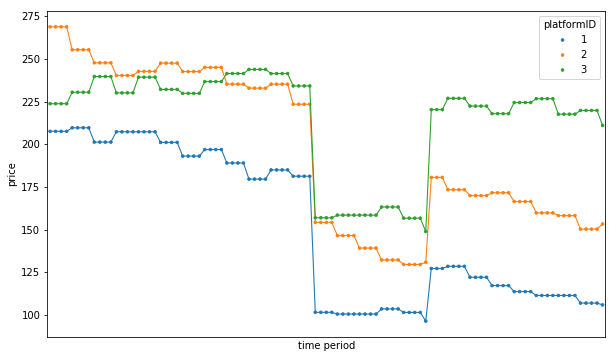

In [368]:
start_time = '2018-11-06'
link = 'https://www.amazon.com/Samsung-Electronics-UN32M4500A-32-Inch-Smart/dp/B073JP6WK4/ref=sr_1_acs_bss_1_1?s=tv&ie=UTF8&qid=1543333023&sr=1-1-acs&keywords=samsung+tv'

def graph_price(link, start_time):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    database_df = pd.read_csv('database.csv',index_col=['Unnamed: 0'])

    # define productID based on link
    try:
        select_df = database_df[database_df['time']>=start_time]
        try:
            # get productID based on link
            productID = database_df['productID'][database_df['link'] == link][0]
            select_df = select_df[['time','platformID','price']][database_df['productID'] == productID]
            select_df = select_df.dropna(axis=0)
            # plot 
            plt.figure(figsize=(10,6))
            g = sns.pointplot(y = select_df['price'],x = select_df['time'],hue = select_df['platformID'],scale=0.4)
            g.set(xticks=[])
            plt.xlabel('time period')
            plt.savefig('price.jpg')
        except:
            raise ValueError('Invalid Link')
    except:
        raise ValueError('Invalid Time')

graph_price(link, start_time)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


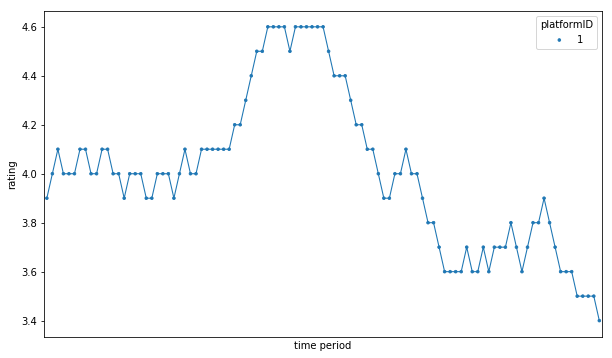

In [369]:
def graph_rating(link, start_time):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    database_df = pd.read_csv('database.csv',index_col=['Unnamed: 0'])

    # define productID based on link
    try:
        select_df = database_df[database_df['time']>=start_time]
        try:
            # get productID based on link
            productID = list(database_df['productID'][database_df['link'] == link])[0]
            select_df = select_df[['time','platformID','rating']][database_df['productID'] == productID]
            select_df = select_df.dropna(axis=0)
            # plot 
            plt.figure(figsize=(10,6))
            g = sns.pointplot(y = select_df['rating'],x = select_df['time'],hue = select_df['platformID'],scale=0.4)
            g.set(xticks=[])
            plt.xlabel('time period')
            plt.savefig('rating.jpg')
        except:
            raise ValueError('Invalid Link')
    except:
        raise ValueError('Invalid Time')

graph_rating(link, start_time)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


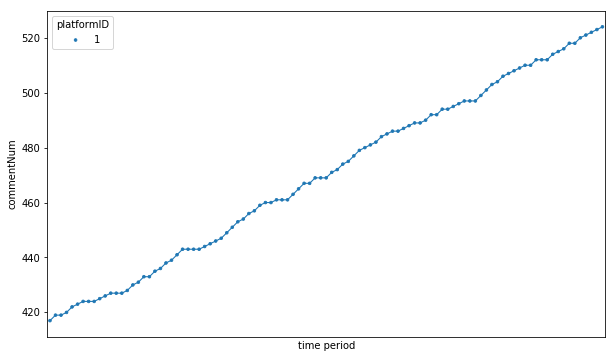

In [370]:
def graph_comment(link, start_time):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    database_df = pd.read_csv('database.csv',index_col=['Unnamed: 0'])

    # define productID based on link
    try:
        select_df = database_df[database_df['time']>=start_time]
        try:
            # get productID based on link
            productID = list(database_df['productID'][database_df['link'] == link])[0]
            select_df = select_df[['time','platformID','commentNum']][database_df['productID'] == productID]
            select_df = select_df.dropna(axis=0)
            # plot 
            plt.figure(figsize=(10,6))
            g = sns.pointplot(y = select_df['commentNum'],x = select_df['time'],hue = select_df['platformID'],scale=0.4)
            g.set(xticks=[])
            plt.xlabel('time period')
            plt.savefig('comment.jpg')
        except:
            raise ValueError('Invalid Link')
    except:
        raise ValueError('Invalid Time')

graph_comment(link, start_time)

## Draw Product Information Table

In [379]:
def table(link):
    import pandas as pd
    database_df = pd.read_csv('database.csv',index_col=['Unnamed: 0'])
    try:
        select_df = database_df[database_df['time']>=start_time]
        try:
            # get productID based on link
            productID = list(database_df['productID'][database_df['link'] == link])[0]
            select_df = select_df[database_df['productID'] == productID]
            table_df = pd.DataFrame()
            platform_list = ['Amazon','Walmart','Ebay','Newegg']
            for i in range(1,5):
                platformID = i
                platformName = platform_list[i-1]
                productName = list(select_df['name'][select_df['platformID'] == platformID])[0]
                try:
                    productName = productName.split()[0]+" ..."
                except:
                    pass
                productLink = list(select_df['link'][select_df['platformID'] == platformID])[0]
                table_df = table_df.append(pd.Series([platformName,productName,productLink]),ignore_index=True)
            table_df.columns = ['Platform Name','Product Name','Product Link']
            string = table_df.to_string(sparsify=True,justify='match-parent',index=False,col_space=10)
            return string
        
        except:
            raise ValueError('Invalid Link')
    except:
        raise ValueError('Invalid Time')

string = table(link)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [380]:
print(string)

Platform Name Product Name                                       Product Link
      Amazon  Samsung ...  https://www.amazon.com/Samsung-Electronics-UN3...
     Walmart  Samsung ...  https://www.walmart.com/ip/Samsung-UN32M4500-3...
        Ebay  Samsung ...  https://www.ebay.com/itm/Samsung-Electronics-U...
      Newegg          NaN                                                NaN
